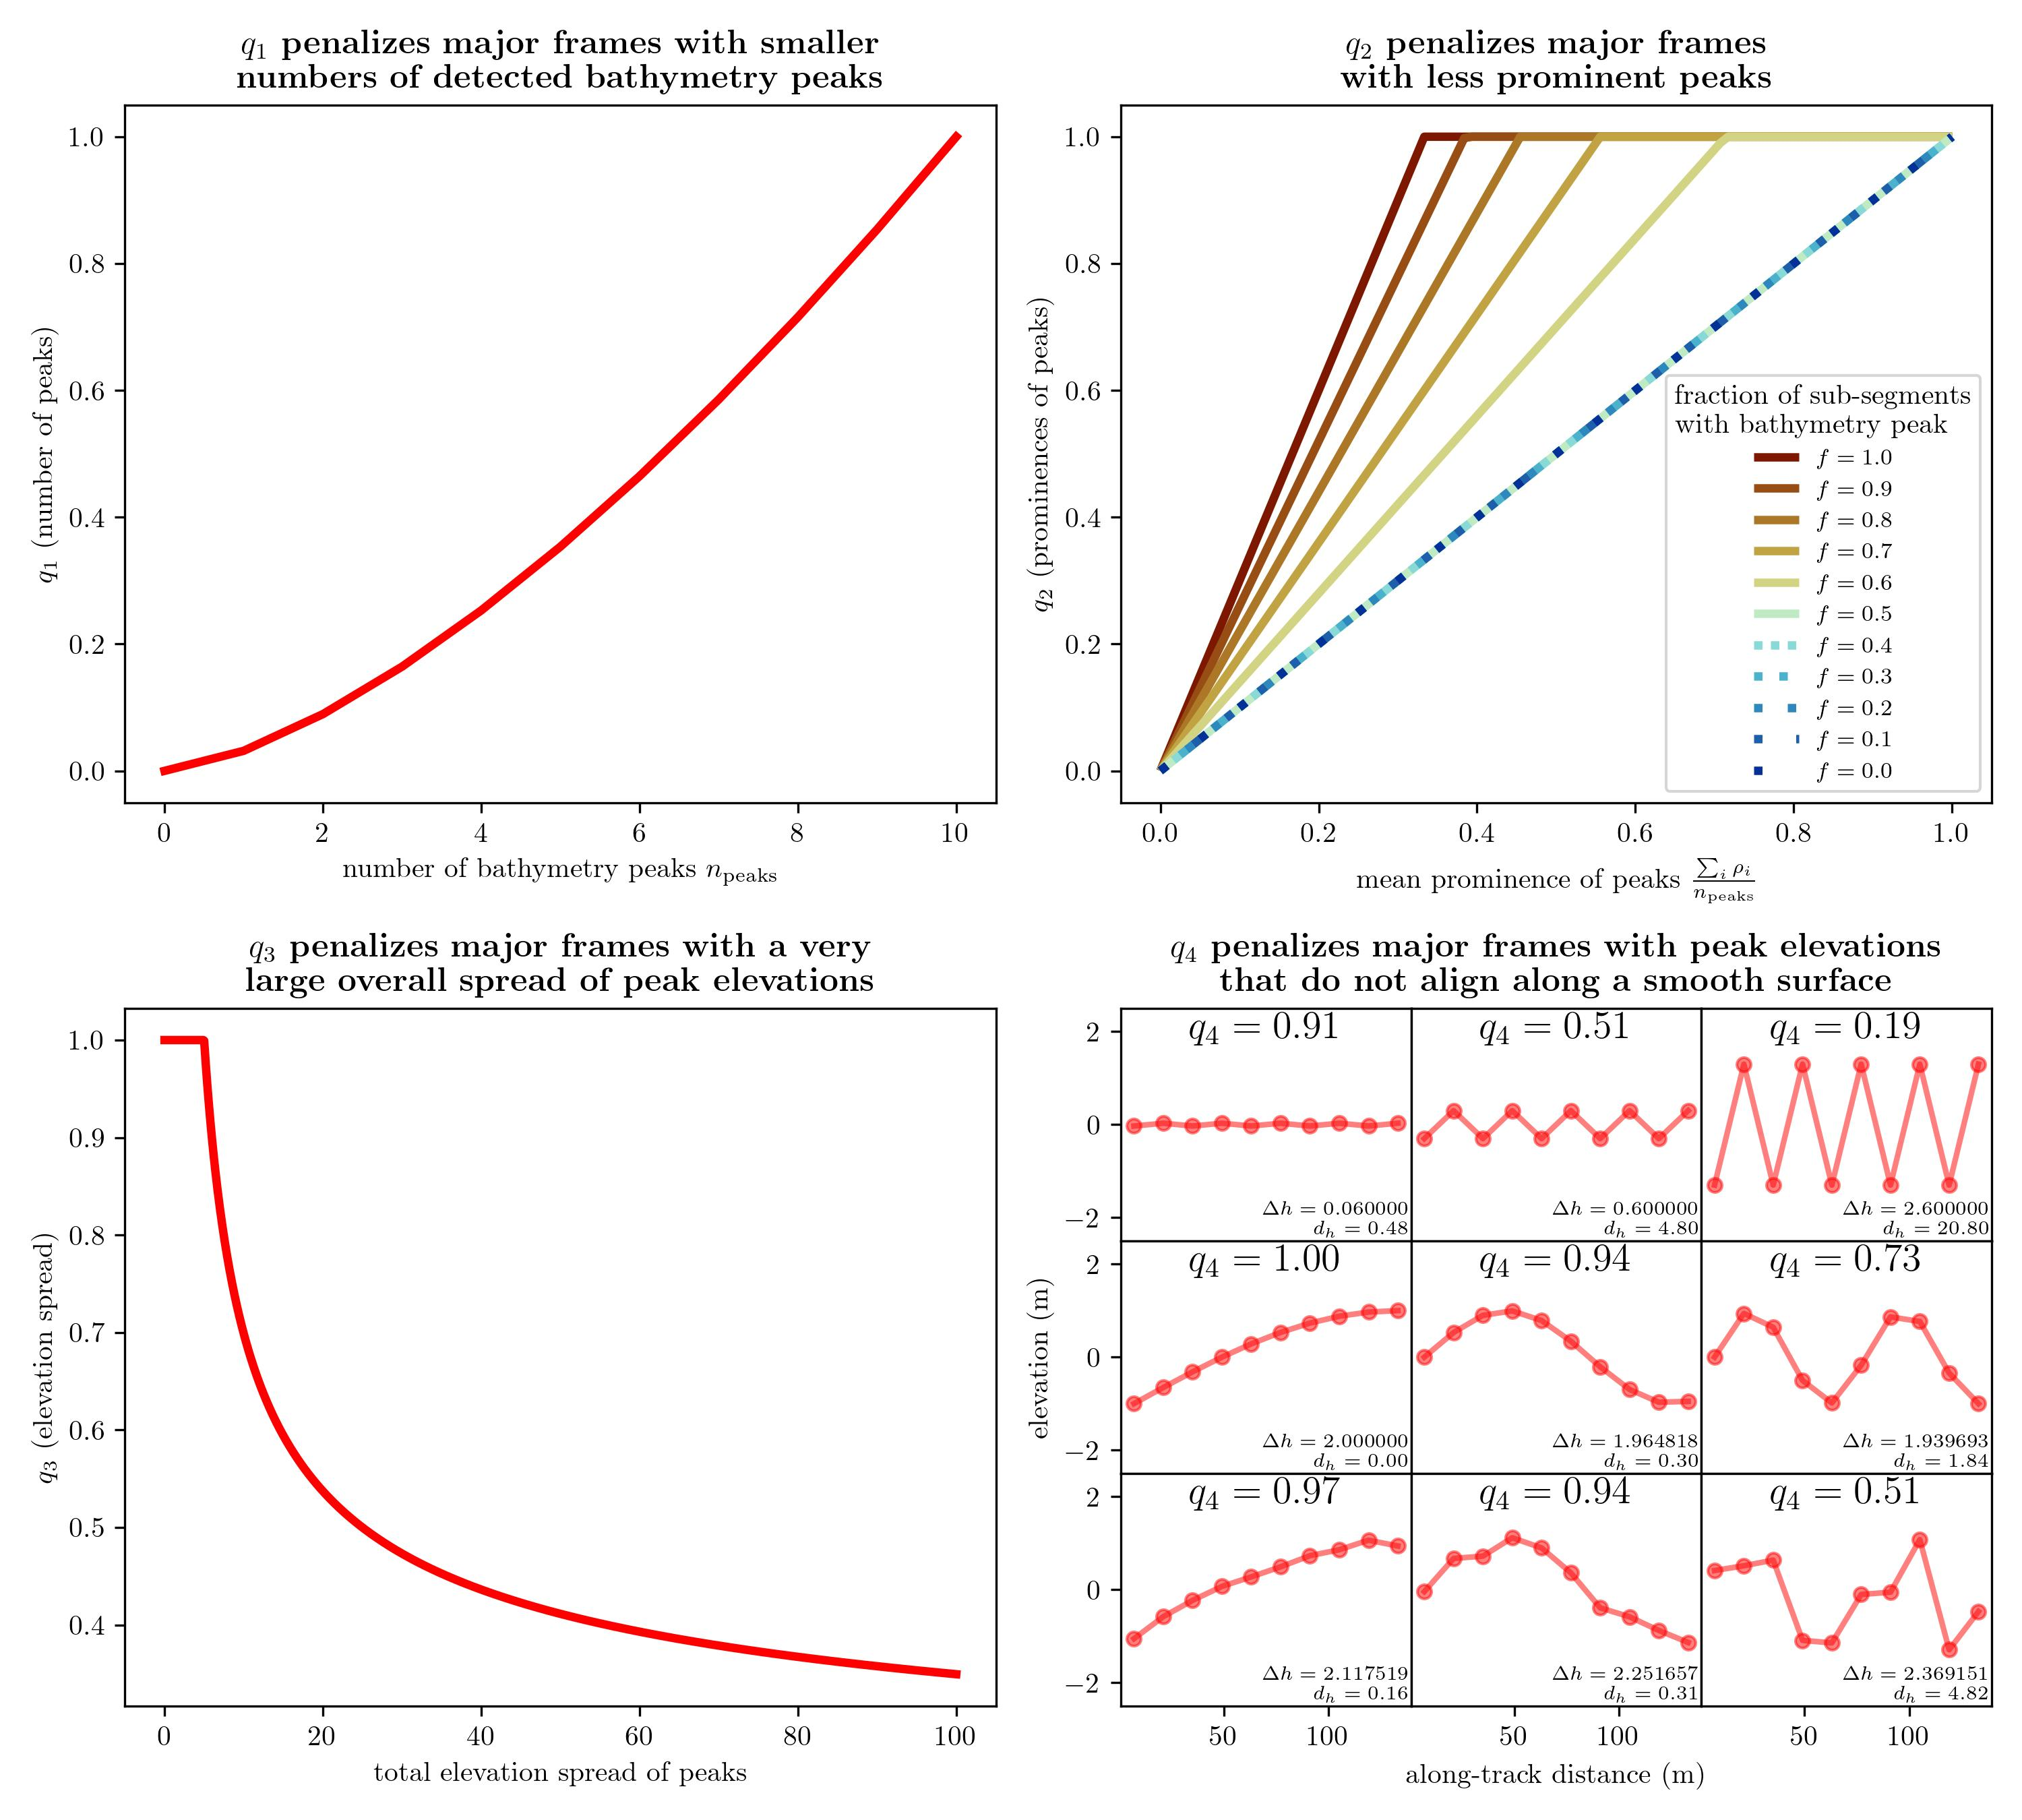

In [1]:
%matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cmcrameri import cm as cmc
from IPython.display import Image, display

figname = '../figures/supplemental-bathy-check-quality-explainer.jpg'

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

plt.close('all')

fig = plt.figure(figsize = [10,9])
gs = fig.add_gridspec(ncols=6, nrows=6)
axs = []
for i in range(4):
    axs.append(fig.add_subplot(gs[3*int(i/2):3*int(i/2)+3, i%2*3:i%2*3+3]))

lwd = 3

#######################################################################
ax = axs[0]
n_subsegs = 10 
n_peaks = np.arange(10,-1, -1)
q1 = (n_peaks / n_subsegs) ** 1.5
ax.plot(n_peaks, q1, 'r-', lw=lwd)
ax.set_ylabel(r'$q_1$ (number of peaks)')
ax.set_xlabel(r'number of bathymetry peaks $n_\text{peaks}$')
tit = r'''\textbf{$q_1$ penalizes major frames with smaller}
\textbf{numbers of detected bathymetry peaks}'''
ax.set_title(tit)

#######################################################################
ax = axs[1]
mean_prominences = np.linspace(0,1,100)
ncol = 11
cols = cmc.roma(np.linspace(0,1,ncol))
for i,frac_2ndreturns in enumerate(np.linspace(1,0,ncol)):
    q2 = [np.clip(mean_prom * ((np.clip(2*frac_2ndreturns, 1, None)-1)*2+1), None, 1) for mean_prom in mean_prominences]
    ax.plot(mean_prominences, q2, color=cols[i,:], label='$f = %.1f$' % frac_2ndreturns,
           ls=(0,(1,np.clip(i-5,0,5))), lw=lwd)
ax.legend(loc='lower right', fontsize=8, title='fraction of sub-segments\nwith bathymetry peak')
ax.set_ylabel(r'$q_2$ (prominences of peaks)')
ax.set_xlabel(r'mean prominence of peaks $\frac{\sum_i \rho_i}{n_\text{peaks}}$')
tit = r'''\textbf{$q_2$ penalizes major frames}
\textbf{with less prominent peaks}'''
ax.set_title(tit)

#######################################################################
ax = axs[2]
h_range = np.linspace(0,100, 1000)
q3 = np.array([np.clip(1/math.log(np.clip(h,1.1,None),5), None, 1) for h in h_range])
ax.plot(h_range, q3, 'r-', lw=lwd)
ax.set_ylabel(r'$q_3$ (elevation spread)')
ax.set_xlabel(r'total elevation spread of peaks')
tit = r'''\textbf{$q_3$ penalizes major frames with a very}
\textbf{large overall spread of peak elevations}'''
ax.set_title(tit)

#######################################################################
ax = axs[3]
ax.axis('off')
for i in range(9):
    axs.append(ax.inset_axes([i%3/3, 1-(int(i/3)+1)/3, 1/3, 1/3]))
tit = r'''\textbf{$q_4$ penalizes major frames with peak elevations}
\textbf{that do not align along a smooth surface}'''
ax.set_title(tit)

n = 10
x = np.linspace(7,133, n)
a1 = 0.03
h1 = [-a1 if i%2==0 else a1 for i in range(n)]
a2 = 0.3
h2 = [-a2 if i%2==0 else a2 for i in range(n)]
a3 = 1.3
h3 = [-a3 if i%2==0 else a3 for i in range(n)]
xx = np.linspace(0, np.pi/2, n)
f = 1
h4 = f * np.sin(xx)*2 - f
h5 = f * np.sin(xx*3.2)
h6 = f * np.sin(xx*7)
d = 0.1
h7 = h4 + np.random.uniform(-d,d,n)
d = 0.2
h8 = h5 + np.random.uniform(-d,d,n)
d = 1.0
h9 = h6 + np.random.uniform(-d,d,n)
hvals = [h1, h2, h3, h4, h5, h6, h7, h8, h9]

for i,elev_2ndpeaks in enumerate(hvals):
    ax = axs[i+4]
    h_range = np.max(elev_2ndpeaks) - np.min(elev_2ndpeaks)
    diffs = np.diff(elev_2ndpeaks)
    dirchange = np.abs(np.diff(np.sign(diffs))) > 1
    total_distance = 0.0
    for i,changed in enumerate(dirchange):
        if changed: total_distance += np.mean((np.abs(diffs)[i], np.abs(diffs)[i+1]))
    alignment_penalty = np.clip(np.clip(h_range, 0.5*n_subsegs, None) / (total_distance + np.clip(h_range, 0.5*n_subsegs, None)), 0, 1)
    ax.plot(x, elev_2ndpeaks,marker='o', alpha=0.5, color='r', markersize=5, lw=2)
    ax.text(0.5, 0.99, '$q_4 = %.2f$' % alignment_penalty, ha='center', va='top', transform=ax.transAxes, fontsize=14)
    txt = r'$\Delta h = %2f$' % h_range
    txt += '\n$d_h = %.2f$' % total_distance
    ax.text(0.99, 0.01, txt, ha='right', va='bottom', transform=ax.transAxes, fontsize=7)
    
for ax in axs[4:]:
    yl = ax.get_ylim()
    ax.set_ylim(np.array(yl)*1.5)
    ax.set_ylim((-2.5,2.5))
    
for i in range(9):
    ax = axs[i+4]
    if i == 3:
        ax.set_ylabel('elevation (m)')
    if i == 7:
        ax.set_xlabel('along-track distance (m)')
    if i%3 != 0:
        ax.yaxis.set_major_locator(ticker.NullLocator())
    if int(i/3) < 2:
        ax.xaxis.set_major_locator(ticker.NullLocator())

fig.tight_layout()
fig.savefig(figname, dpi=300)
plt.close(fig)
display(Image(figname))